In [1]:
import numpy as np
import pandas as pd
from src.measurements import Measurements
from src.run import sample_measurement
from src.config import Config
import warnings

warnings.filterwarnings('ignore')

Organization for helpful written instructions:
 - things you need to change
 - input check information
 - outputs and diagnostics
 - commentary about what to look for (red flags and green)

# Shouldn't use if mass loss in your measurements is >50%
# other pre-input QA/QC notes
# if you make change in files, re-run all the cells etc.

In [2]:
DATAFILE = 'data/Pickard_NH_fish.csv'
SAMPLE_NUMBER = 0

In [3]:

df = pd.read_csv(DATAFILE)
df.head()

,Sample,Units,config,C3pre,C4pre,C5pre,C6pre,C7pre,C8pre,C3post,...,7:3 FTmeas,8:2 FTmeas,C4 ECFmeas,C5 ECFmeas,C6 ECFmeas,C7 ECFmeas,C8 ECFmeas,PFOS,PFOSMDL,CXerr
0,LOC3PS2,nM,unknown_fish.yaml,0,0,0,0.026594,0.055918,0.172588,3.288037,...,0.2166,0.069,10.8085,NaN,1.8838,NaN,0.3946,0.4210,0.1749,0.1
1,LOC3YP1,nM,unknown_fish.yaml,0,0,0,0.000000,0.090769,0.227561,0.000000,...,0.1282,0.164,9.5353,NaN,1.2582,NaN,0.3824,5.0845,0.1749,0.1
2,LOC4BGcomp,nM,unknown_fish.yaml,0,0,0,0.077754,1.279085,0.152861,0.000000,...,0.2577,0.000,0.8111,NaN,0.1889,NaN,5.1716,40.2684,0.1749,0.1
3,LOC5BGcomp,nM,unknown_fish.yaml,0,0,0,0.000000,0.009746,0.085006,4.238232,...,0.0291,0.000,0.1766,NaN,0.0000,NaN,0.0216,0.0000,0.1749,0.1
4,LOC5LM1_Dup,nM,unknown_fish.yaml,0,0,0,0.078527,0.000000,0.000000,5.183628,...,0.0247,0.000,0.7946,NaN,0.0000,NaN,0.0387,1.8174,0.1749,0.1


In [4]:
sample_name = df['Sample'][SAMPLE_NUMBER]
print('Sample ' + sample_name)
df_row = df.iloc[SAMPLE_NUMBER]
measurements = Measurements.from_row(df_row)
measurements.print()

Sample LOC3PS2
PFCAs: {   'C3': Measurement(value=3.28803708, error=0.6363961030678928, MDL=3.9888),
    'C4': Measurement(value=3.064358273, error=0.4242640687119285, MDL=0.6062),
    'C5': Measurement(value=2.407033854, error=0.21213203435596426, MDL=0.3746),
    'C6': Measurement(value=0, error=0.4242640687119285, MDL=0.0903),
    'C7': Measurement(value=0.342753647, error=0.07071067811865477, MDL=0.0985),
    'C8': Measurement(value=0, error=0.21213203435596426, MDL=0.0776)}
targeted_precursors: {   '4:2 FT': Measurement(value=0, error=0.1, MDL=None),
    '5:3 FT': Measurement(value=0, error=0.1, MDL=None),
    '6:2 FT': Measurement(value=0.1758, error=0.1, MDL=None),
    '7:3 FT': Measurement(value=0.2166, error=0.1, MDL=None),
    '8:2 FT': Measurement(value=0.069, error=0.1, MDL=None),
    'C4 ECF': Measurement(value=10.8085, error=0.1, MDL=None),
    'C6 ECF': Measurement(value=1.8838, error=0.1, MDL=None),
    'C8 ECF': Measurement(value=0.3946, error=0.1, MDL=None)}
PFOS: Mea

In [5]:
config = Config.from_yaml(measurements.associated_config)
prior_name = config.prior_name
config.print()

Config object:
{   'ecf_relativechain_yield_errors': [   0.0126,
                                          0.16,
                                          0.0338,
                                          0.0645,
                                          0.0226,
                                          0.0058,
                                          0,
                                          0],
    'ecf_relativechain_yields': [   0.0043,
                                    0.862,
                                    0.0262,
                                    0.026,
                                    0.0061,
                                    0.0011,
                                    0.09,
                                    0],
    'ft_relativechain_yield_errors': [   0.0586,
                                         0.11,
                                         0.0986,
                                         0.0488,
                                         0.033,
          

In [6]:
# Sampling options:
TARGET_EFFECTIVE_STEPS = 2500 # the "effective sample size" desired, which accounts for autocorrelation in raw samples.
MAX_STEPS = 25000
alpha = 0.55#-1 # if this is a number less than zero, the sampler will tune alpha to find an efficient acceptance rate.
MAX_DEPTH = 3 # the depth of search in the alpha-tuning process; will have no effect if alpha is set > 0.


In [7]:
posterior = sample_measurement(config, measurements,
                                 prior_name=prior_name,
                                 Nincrement=2500,
                                 TARGET_EFFECTIVE_STEPS=TARGET_EFFECTIVE_STEPS,
                                 MAX_STEPS=MAX_STEPS,
                                 MAX_DEPTH=MAX_DEPTH,
                                 alpha=alpha)

acceptance rate is 0.49 when alpha is 0.55
Sampling posterior in 2500-iteration increments.
After 2500 iterations, autocorr time: unavailable
After 5000 iterations, autocorr time: 47.46045246414844
After 7500 iterations, effective number of samples:                    4836
SAMPLE DONE


In [8]:
summary = posterior.summary_table()
summary

,Statistic,4:2 FT,5:3 FT,6:2 FT,7:3 FT,8:2 FT,9:3 FT,10:2 FT,C4 ECF,C5 ECF,C6 ECF,C7 ECF,C8 ECF,C9 ECF,C10 ECF,Total precursors
0,Mean,0.012644,0.002349,1.227078,4.834915,12.707319,1.980427,0.002496,1.378677e+07,0.023668,22942.859204,271.924725,0.587237,231.612461,8.490592,1.381025e+07
1,Geometric mean,0.006599,0.002113,0.814625,2.180710,5.508865,0.162367,0.002183,3.967643e+03,0.008845,102.334976,54.429032,0.543253,1.680800,1.035350,5.425255e+03
2,5.0th percentile,0.001331,0.001084,0.206520,0.320147,0.799015,0.005074,0.001080,3.484429e+01,0.001468,3.115868,1.989335,0.313581,0.013964,0.051079,1.077030e+02
3,25.0th percentile,0.002941,0.001526,0.435163,0.881923,2.396078,0.037484,0.001521,3.448060e+02,0.003464,16.725630,16.910500,0.409187,0.210519,0.273220,5.570395e+02
4,50.0th percentile,0.005996,0.002027,0.765011,2.034543,5.214607,0.153983,0.002055,2.958594e+03,0.007591,80.675271,58.970975,0.519842,1.589743,0.951731,3.468758e+03
5,75.0th percentile,0.013256,0.002806,1.459394,5.058603,12.016225,0.639020,0.002939,3.137116e+04,0.019183,471.551506,193.451872,0.689223,11.373167,3.592374,3.261285e+04
6,95.0th percentile,0.045515,0.004717,3.835090,18.583651,45.607474,6.217535,0.005388,1.305949e+06,0.090073,7796.279255,1040.925119,1.088750,270.139473,27.639658,1.314643e+06


# add language about what means when geomeans/quantiles don't sum to their total equivalent

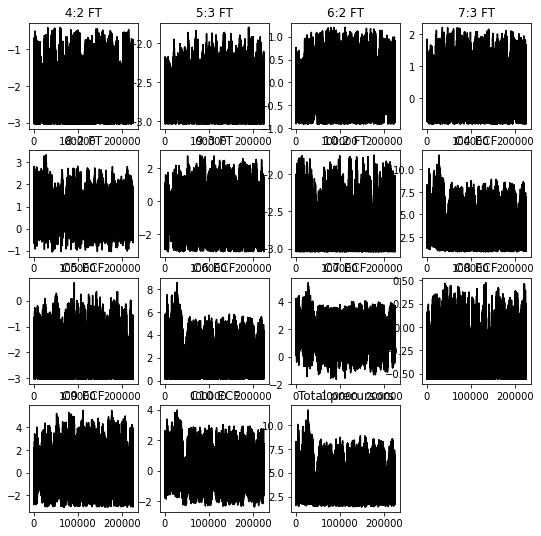

In [9]:
posterior.show_traces()

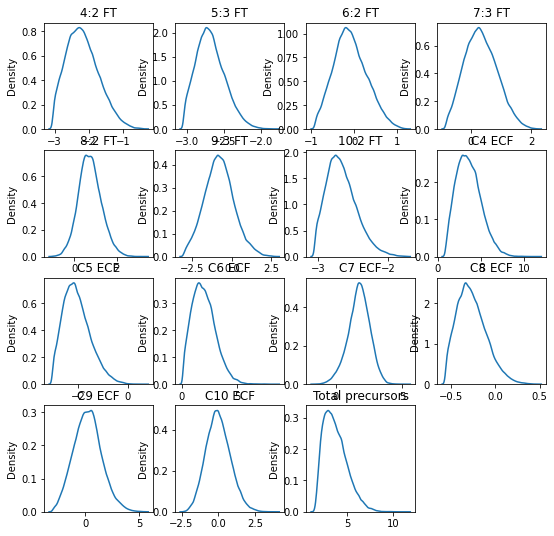

In [10]:
posterior.show_kdes()

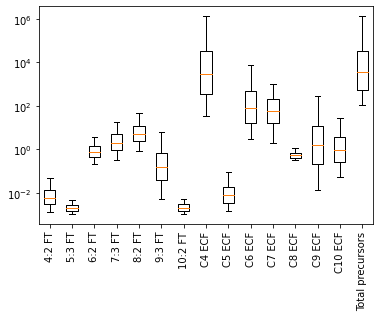

In [11]:
posterior.boxplot()

(<Figure size 432x288 with 1 Axes>, <Axes: ylabel='Concentration'>)

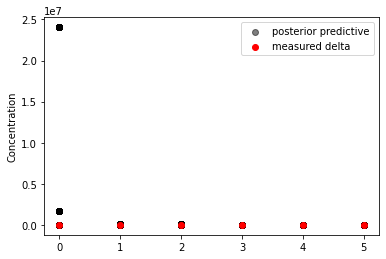

In [12]:
top_delta = [c.value for k,c in measurements.PFCAs.items()]
posterior.posterior_predictive(top_delta=top_delta, n_posterior=5000)

In [13]:
OUTPUT_NAME = f'infer_out/{sample_name}'
posterior.save(OUTPUT_NAME)

In [15]:
from src.posterior import Posterior
# # won't be able to do the posterior predictive with this saved format
posterior = Posterior.from_save(f'infer_out/{sample_name}')

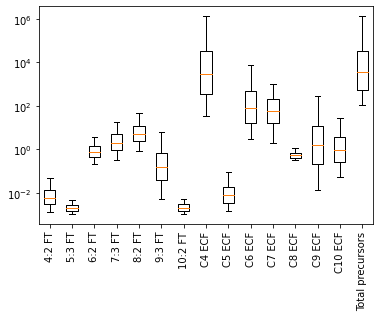

In [16]:
# to compare to above
posterior.boxplot()